In [2]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

584


In [3]:
import cv2
from tqdm import tqdm

In [4]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 413


In [5]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [6]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed


# Part 2: watershed

In [9]:
for _fov_id, _fov_name in enumerate(fovs):
    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(ref_image_file, 
                                                  CorrectionFolder=correction_folder, 
                                                  DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, 
                                              DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488,405])
    _cls._corr_illumination()
    _cls.im_750 = _cls.im_750[0::4]
    _cls.im_488 = _cls.im_488[0::4]
    _cls.image_size = np.array(np.shape(_ref_im))
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(correction_channels=[750], corr_chromatic=False)

    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)

    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, 1.6)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    #break

\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_0.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_1.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_2.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_3.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_4.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_5.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_6.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershe

-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.002s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.157s.
- Finished illumination correction in 1.204s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_293.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.578s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for ch

-- corrected illumination for channel 405 in 4.437s.
- Finished illumination correction in 13.625s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-2.000e-02 -1.236e+01  2.914e+01] in 0.547s.
-- drift 1: [-1.000e-02 -1.215e+01  2.926e+01] in 0.547s.
-- drift 2: [-2.000e-02 -1.230e+01  2.922e+01] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.66666667e-02 -1.22700000e+01  2.92066667e+01] for channel: 750
-- finish warpping channel 750 in 16.750s.
-- finish warpping in 16.750s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_296.npy
- run watershed in 83.257s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_296.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\2022

- Loaded images for channels:['488'] in 1.672s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.219s.
- Finished illumination correction in 1.313s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_300.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 4.937s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.531s.
-- corrected illum

-- drift 0: [  0.05 -12.54  20.15] in 0.609s.
-- drift 1: [  0.04 -12.51  20.14] in 0.609s.
-- drift 2: [  0.05 -12.43  20.15] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.04666667 -12.49333333  20.14666667] for channel: 750
-- finish warpping channel 750 in 16.422s.
-- finish warpping in 16.422s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_303.npy
- run watershed in 81.484s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_303.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_304.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_304.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sam

- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.141s.
- Finished illumination correction in 1.188s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_307.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.609s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.437s.
-- corrected illum

-- drift 0: [  0.   -12.05  11.12] in 0.609s.
-- drift 1: [  0.   -11.6   11.11] in 0.641s.
-- drift 2: [  0.   -11.86  11.07] in 0.610s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.         -11.83666667  11.1       ] for channel: 750
-- finish warpping channel 750 in 16.531s.
-- finish warpping in 16.531s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_310.npy
- run watershed in 83.109s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_310.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_311.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_311.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sam

- Loaded images for channels:['488'] in 0.937s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.157s.
- Finished illumination correction in 1.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_314.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.531s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.563s.
-- corrected illum

-- drift 0: [ -0.02 -11.89   6.65] in 0.578s.
-- drift 1: [ -0.03 -11.78   6.75] in 0.578s.
-- drift 2: [ -0.02 -12.02   6.69] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.02333333 -11.89666667   6.69666667] for channel: 750
-- finish warpping channel 750 in 16.510s.
-- finish warpping in 16.510s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_317.npy
- run watershed in 82.544s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_317.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_318.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_318.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sam

- Loaded images for channels:['488'] in 0.937s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.156s.
- Finished illumination correction in 1.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_321.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.563s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.624s.
-- corrected illum

-- drift 0: [-1.000e-02 -1.192e+01  7.100e+00] in 0.564s.
-- drift 1: [ -0.02 -12.05   6.91] in 0.573s.
-- drift 2: [  0.   -11.96   6.98] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.00000000e-02 -1.19766667e+01  6.99666667e+00] for channel: 750
-- finish warpping channel 750 in 16.377s.
-- finish warpping in 16.377s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_324.npy
- run watershed in 79.185s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_324.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_325.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_325.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\2022

- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_328.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.562s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.578s.
-- corrected illum

-- drift 0: [ -0.02 -11.62  13.78] in 0.578s.
-- drift 1: [  0.   -11.58  13.63] in 0.594s.
-- drift 2: [ -0.02 -11.19  13.88] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.33333333e-02 -1.14633333e+01  1.37633333e+01] for channel: 750
-- finish warpping channel 750 in 16.408s.
-- finish warpping in 16.408s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_331.npy
- run watershed in 80.594s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_331.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_332.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_332.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1

- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.267s.
- Finished illumination correction in 1.282s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_335.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.593s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.814s.
-- corrected illum

-- drift 0: [ 0.01 -9.59  8.28] in 0.547s.
-- drift 1: [ 0.01 -9.54  8.38] in 0.563s.
-- drift 2: [ 0.03 -9.3   8.67] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 0.01666667 -9.47666667  8.44333333] for channel: 750
-- finish warpping channel 750 in 16.344s.
-- finish warpping in 16.344s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_338.npy
- run watershed in 80.812s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_338.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_339.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_339.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Co

- Loaded images for channels:['488'] in 1.010s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 1.187s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_342.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.671s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.484s.
-- corrected illum

-- corrected illumination for channel 405 in 4.969s.
- Finished illumination correction in 17.078s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -12.44   4.46] in 0.672s.
-- drift 1: [  0.   -12.35   4.55] in 0.610s.
-- drift 2: [  0.06 -12.44   4.51] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.02       -12.41         4.50666667] for channel: 750
-- finish warpping channel 750 in 16.375s.
-- finish warpping in 16.375s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_345.npy
- run watershed in 64.443s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_345.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_346

- Loaded images for channels:['488'] in 0.922s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_349.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.578s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.391s.
-- corrected illum

-- drift 0: [ 1.000e-02 -1.211e+01  1.023e+01] in 0.578s.
-- drift 1: [ 1.000e-02 -1.253e+01  1.004e+01] in 0.547s.
-- drift 2: [  0.   -12.41  10.  ] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 6.66666667e-03 -1.23500000e+01  1.00900000e+01] for channel: 750
-- finish warpping channel 750 in 16.360s.
-- finish warpping in 16.360s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_352.npy
- run watershed in 70.140s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_352.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_353.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_353.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromati

- Loaded images for channels:['488'] in 0.906s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_356.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.516s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.484s.
-- corrected illum

-- drift 0: [  0.   -12.5    5.46] in 0.578s.
-- drift 1: [ 1.000e-02 -1.221e+01  5.850e+00] in 0.547s.
-- drift 2: [  0.   -12.67   5.88] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 3.33333333e-03 -1.24600000e+01  5.73000000e+00] for channel: 750
-- finish warpping channel 750 in 16.250s.
-- finish warpping in 16.250s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_359.npy
- run watershed in 67.796s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_359.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_360.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_360.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\2022

- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.156s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_363.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.532s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.400s.
-- corrected illum

-- drift 0: [-1.00e-02 -1.58e+01  7.90e+00] in 0.562s.
-- drift 1: [-1.000e-02 -1.546e+01  7.870e+00] in 0.547s.
-- drift 2: [ -0.03 -15.49   7.73] in 0.515s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.01666667 -15.58333333   7.83333333] for channel: 750
-- finish warpping channel 750 in 16.275s.
-- finish warpping in 16.275s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_366.npy
- run watershed in 72.390s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_366.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_367.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_367.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\2022

- Loaded images for channels:['488'] in 0.971s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_370.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.546s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.375s.
-- corrected illum

-- drift 0: [ -0.09 -11.64   8.25] in 0.579s.
-- drift 1: [ -0.02 -12.13   8.1 ] in 0.531s.
-- drift 2: [  0.   -11.9    8.06] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.03666667 -11.89         8.13666667] for channel: 750
-- finish warpping channel 750 in 16.264s.
-- finish warpping in 16.264s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_373.npy
- run watershed in 73.483s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_373.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_374.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_374.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sam

- Loaded images for channels:['488'] in 0.937s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_377.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.595s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.406s.
-- corrected illum

-- drift 0: [ -0.04 -12.68   5.95] in 0.562s.
-- drift 1: [ -0.02 -12.69   5.86] in 0.531s.
-- drift 2: [ -0.02 -12.7    6.04] in 0.515s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.02666667 -12.69         5.95      ] for channel: 750
-- finish warpping channel 750 in 16.359s.
-- finish warpping in 16.359s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_380.npy
- run watershed in 73.376s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_380.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_381.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_381.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sam

- Loaded images for channels:['488'] in 0.953s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_384.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.532s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.412s.
-- corrected illum

-- drift 0: [ 1.000e-02 -1.373e+01  9.830e+00] in 0.516s.
-- drift 1: [-1.000e-02 -1.367e+01  9.790e+00] in 0.594s.
-- drift 2: [ -0.05 -13.72   9.69] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.01666667 -13.70666667   9.77      ] for channel: 750
-- finish warpping channel 750 in 16.247s.
-- finish warpping in 16.247s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_387.npy
- run watershed in 67.968s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_387.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_388.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_388.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\2

- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_391.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.484s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.375s.
-- corrected illum

-- drift 0: [ 1.000e-02 -1.318e+01  1.493e+01] in 0.562s.
-- drift 1: [  0.   -13.38  14.56] in 0.515s.
-- drift 2: [  0.   -13.3   14.82] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 3.33333333e-03 -1.32866667e+01  1.47700000e+01] for channel: 750
-- finish warpping channel 750 in 16.266s.
-- finish warpping in 16.266s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_394.npy
- run watershed in 63.452s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_394.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_395.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_395.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\2022

- Loaded images for channels:['488'] in 0.985s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.079s.
- Finished illumination correction in 1.126s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_398.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.578s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.390s.
-- corrected illum

-- drift 0: [ -0.02 -14.27   7.59] in 0.578s.
-- drift 1: [  0.   -13.87   7.84] in 0.564s.
-- drift 2: [ 1.000e-02 -1.345e+01  8.120e+00] in 0.515s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-3.33333333e-03 -1.38633333e+01  7.85000000e+00] for channel: 750
-- finish warpping channel 750 in 16.204s.
-- finish warpping in 16.204s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_401.npy
- run watershed in 69.155s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_401.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_402.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_402.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\2022

- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_405.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.624s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.390s.
-- corrected illum

-- drift 0: [  0.04 -12.59  10.4 ] in 0.564s.
-- drift 1: [  0.   -12.73   9.89] in 0.516s.
-- drift 2: [  0.07 -12.64  10.11] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.03666667 -12.65333333  10.13333333] for channel: 750
-- finish warpping channel 750 in 16.234s.
-- finish warpping in 16.234s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\segmentation_label_408.npy
- run watershed in 66.015s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\Segmentation\watershed\segmentation_label_408.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H0M1\Conv_zscan_409.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_409.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sam

- Loaded images for channels:['488'] in 0.906s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction in 1.140s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221022-hM1_hM1_Cx28_sample1\H11M12\Conv_zscan_412.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.468s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.406s.
-- corrected illum

<IPython.core.display.Javascript object>


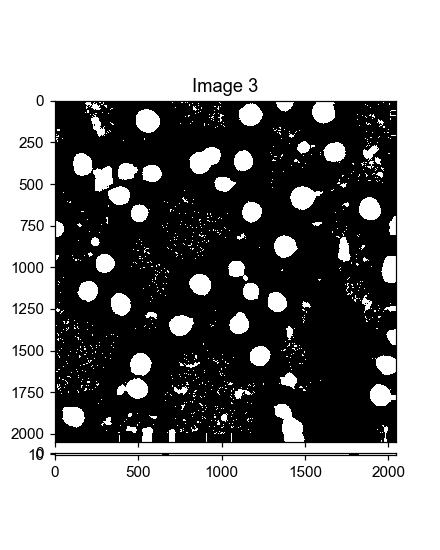

In [11]:
visual_tools.imshow_mark_3d_v2([polyt_im, waterIm, waterMask])

<IPython.core.display.Javascript object>


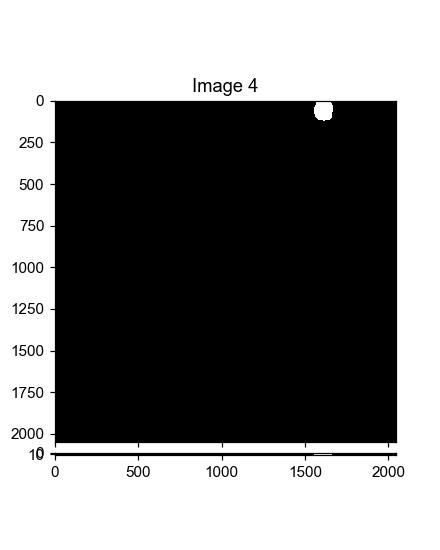

In [13]:
visual_tools.imshow_mark_3d_v2([polyt_im, corr_labels3d, new_labels, corr_labels3d==1])